# Pre-Processing of Data

In [1]:
# Misc
import os
import sys
from timeit import default_timer as timer 
import datetime
now = datetime.datetime.now()

# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import welch


# Sanity check for jupyter notebooks
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\gabri\Documents\GitHub\IceClassic\sandbox\content



# [Nenana Ice Classic](https://www.nenanaakiceclassic.com/)
> The Ice Classic is Alaska's greatest guessing game! 
In Nenana during 1917 a group of engineers surveying for the Alaska Railroad bet $800 putting in their guesses when the river would break up. This fun little guessing game has turned into an incredible tradition that has now continued for over 100 years! 
Buy and turn in your $3.00 ticket between February 1st and April 5th to be involved in this long running Alaskan tradition. 

# Motivation 
We want to 
- Predict day of break up
- Predict time of break up
- Create betting strategy
- Have fun


# Loading the dataframe
We have compiled some data that might be useful, the file is available in [Github](https://github.com/iceclassic/sandbox/blob/main/content/Time_series_DATA.txt)

The source and explanation of each column is in the txt.

In [2]:
Data=pd.read_csv('https://github.com/iceclassic/sandbox/blob/main/content/Time_series_DATA.txt?raw=true',index_col=0,skiprows=289)

Frist lets add some data that I forgot to add to the merged df that is up on github (later I need to run these cells,export new df, and add the source description of column to new file)

In [3]:
#include this changes in the Datafile
Data['Fairbanks: Air Temperature [C]']=(Data['Fairbanks: Air Temperature [C]']-32)*(5/9)
Data['Predicted ice thickness [m]']=1.23*Data['Predicted ice thickness [m]']
Data['Noisy predicted ice thickness [m]']=1.23*Data['Noisy predicted ice thickness [m]']

In [4]:
# include this data to
PDO=pd.read_csv('PDO.txt',sep='\t')
AO=pd.read_csv('AO.txt',sep=' ')

In [5]:
# Melt the DataFrame to convert columns to rows
melted_df = pd.melt(PDO, id_vars='Year', var_name='Month', value_name='Value')

# Combine 'Year' and 'Month' columns into a new column representing the date
melted_df['Date'] = melted_df['Year'].astype(str) + '-' + melted_df['Month']+'01'

melted_df['Date'] = pd.to_datetime(melted_df['Date'])
melted_df.set_index(['Date'],inplace=True)

# Display the resulting DataFrame
melted_df.rename(columns={'Value':'Global: Pacific decadal oscillation index'},inplace=True)
melted_df.drop(columns=['Year','Month'],inplace=True)

#melted_df.index= pd.to_datetime(melted_df.index)

# Sort the DataFrame by the date column
melted_df.sort_index(inplace=True)

melted_df = melted_df[melted_df.index <'2024-02-01']
Data=Data.merge(melted_df,right_index=True,left_index=True,how='outer')

In [6]:
# Melt the DataFrame to convert columns to rows
melted_df = pd.melt(AO, id_vars='Year', var_name='Month', value_name='Value')

# Combine 'Year' and 'Month' columns into a new column representing the date
melted_df['Date'] = melted_df['Year'].astype(str) + '-' + melted_df['Month']+'01'

melted_df['Date'] = pd.to_datetime(melted_df['Date'])
melted_df.set_index(['Date'],inplace=True)

# Display the resulting DataFrame
melted_df.rename(columns={'Value':'Global: Artic oscillation index'},inplace=True)
melted_df.drop(columns=['Year','Month'],inplace=True)

#melted_df.index= pd.to_datetime(melted_df.index)

# Sort the DataFrame by the date column
melted_df.sort_index(inplace=True)

melted_df = melted_df[melted_df.index <'2024-02-01']
Data=Data.merge(melted_df,right_index=True,left_index=True,how='outer')

# Compiled Data

In [7]:
Data.index=pd.to_datetime(Data.index)
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41351 entries, 1854-01-01 to 2024-02-06
Data columns (total 26 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Predicted ice thickness [m]                        38563 non-null  float64
 4   Noisy predicted ice thickness [m]                  25762 non-null  float64
 5   Nenana: Rainfall [mm]                              29547 non-null  float64
 6   Nenana: Snowfall [mm]                              19945 non-null  float64
 7   Nenana: Snow depth [mm]                            15984 non-null  float64
 8   Nenana: Mean water temperature [C]                 2418 non-null   fl

# Visualizing the dataframe
The data is a dataframe, with the index a datetime object, so it is very easy to plot specific columns.
I've also added the columns `Data['Days since start of year']`and `Data[Days until break up ]`, that we can use as x-axis to plot the variables in a more convenient way.

Using the command plot in columns that are *sparse* might not work, use scatter, or simply extract column, delete rows without data `Data['colname'].dropna()` and re-define index as datetime object (
`Data.index=pd.to_datetime(Data.index)`)

### Temperature Data

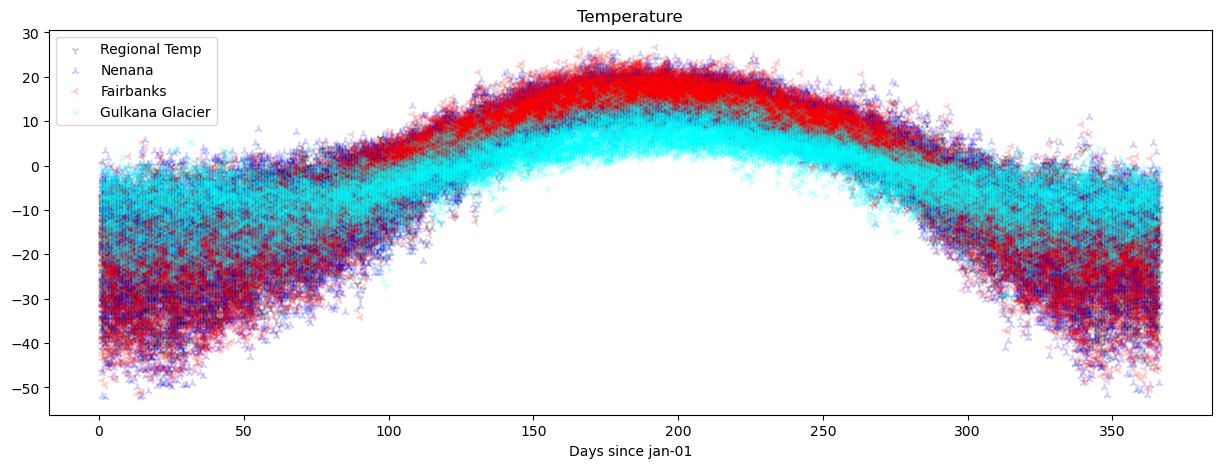

In [8]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5)) 
plt.scatter(Data['Days since start of year'],Data['Regional: Air temperature [C]'],color='k',marker='1',alpha=0.2,label='Regional Temp')
plt.scatter(Data['Days since start of year'],Data['Nenana: Air temperature [C]'],color='b',marker='2',alpha=0.2,label='Nenana')
plt.scatter(Data['Days since start of year'],Data['Fairbanks: Air Temperature [C]'],color='r',marker='3',alpha=0.2,label='Fairbanks')
plt.scatter(Data['Days since start of year'],Data[' Gulkana Temperature [C]'],color='cyan',marker='4',alpha=0.2,label='Gulkana Glacier')
plt.legend()
plt.xlabel('Days since jan-01')
plt.title("Temperature")
plt.show()

What we learn:
- Temperature in Nenana is very similar to Fairbanks and regional measurements from  a 1$ \degree $ grid. We assume no microclimate near the tripod, at least in terms of temperature.
- Temperature in Gulkana glaciers is different, which is obvious as it is over 1500m and 200km south-west. The direct effects on the ice near Nenana will be negligible, but it might be useful to explore the effects in the melting of the glacier (see columns 20-23 ) and discharge.
- Lets ignore `Nenana` and `Fairbanks`temperatures time series and work instead with `Regional: Air temperature [C]'`, as it has more data. 


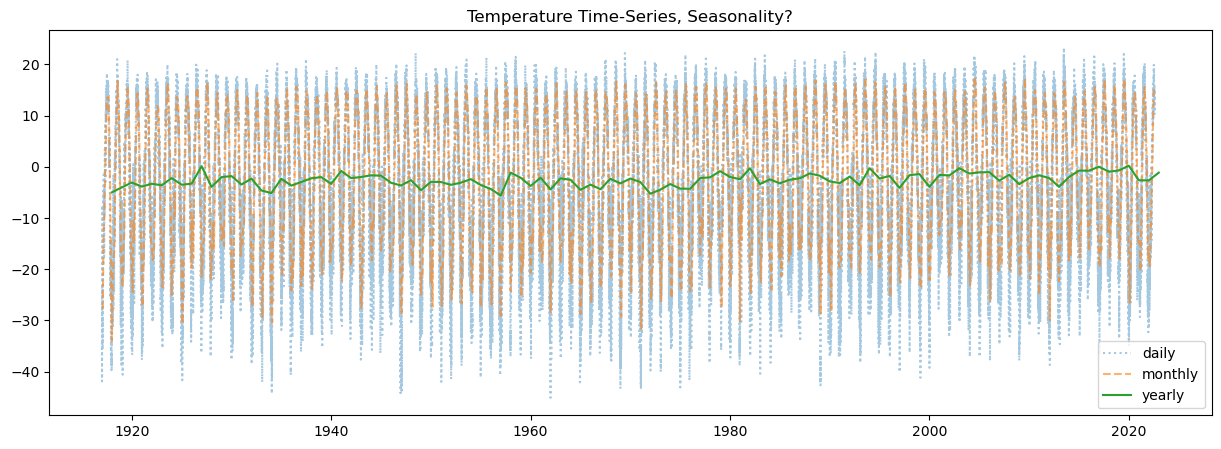

In [9]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5)) 
plt.plot(Data['Regional: Air temperature [C]'],label='daily',alpha=0.4,linestyle='dotted')
plt.plot(Data['Regional: Air temperature [C]'].resample('M').mean().dropna(),label='monthly',alpha=0.6,linestyle='dashed')
plt.plot(Data['Regional: Air temperature [C]'].resample('Y').mean().dropna(),label='yearly')
plt.title('Temperature Time-Series, Seasonality?')
plt.legend()
plt.show()

At a glance, there does not seem to be any overarching growing trend,  or frequency component (besides the normal seasonal variation). A more detailed analysis might reveal other trends (from PSD), but for our purpose we will disregard them, and assume the time-series is stationary.

But we know that there are global oscillation that impact the weather, such as, ENSO, PDO and AO. 

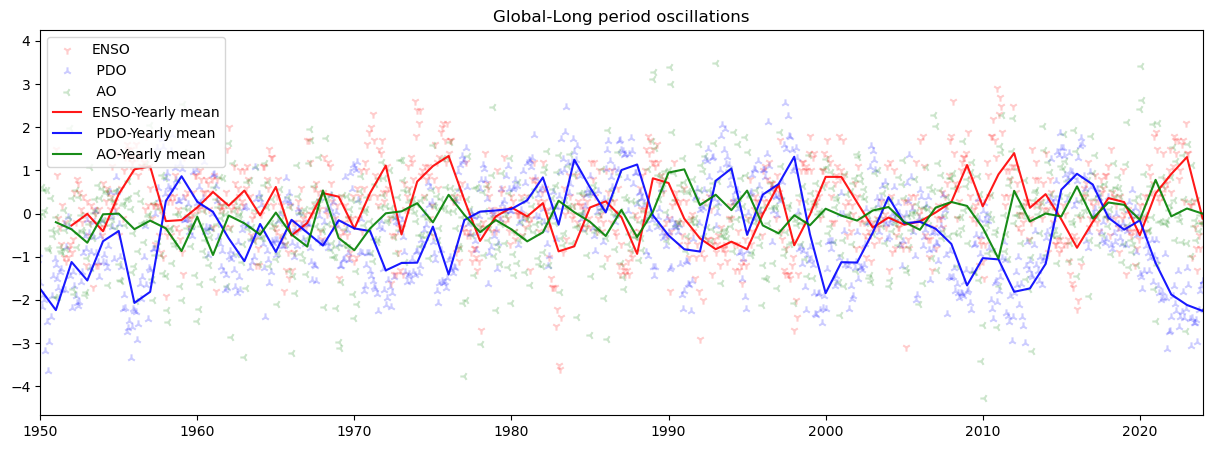

In [10]:
ENSO=Data['Global: ENSO-Southern oscillation index'].copy().resample('Y').mean().dropna()
ENSO.index=pd.to_datetime(ENSO.index)
PDO=Data['Global: Pacific decadal oscillation index'].copy().resample('Y').mean().dropna()
PDO.index=pd.to_datetime(PDO.index)
AO=Data['Global: Artic oscillation index'].copy().resample('Y').mean().dropna()
AO.index=pd.to_datetime(AO.index)
fig, ax1 = plt.subplots(1,1,figsize=(15,5)) 

plt.scatter(Data.index,Data['Global: ENSO-Southern oscillation index'],label='ENSO',alpha=0.2,marker='1',color='r')
plt.scatter(Data.index,Data['Global: Pacific decadal oscillation index'],label=' PDO',alpha=0.2,marker='2',color='b')
plt.scatter(Data.index,Data['Global: Artic oscillation index'],label=' AO',alpha=0.2,marker='3',color='g')

plt.plot(ENSO,label='ENSO-Yearly mean',alpha=0.9,color='r')
plt.plot(PDO,label=' PDO-Yearly mean',alpha=0.9,color='b')
plt.plot(AO,label=' AO-Yearly mean',alpha=0.9,color='g')
plt.title('Global-Long period oscillations')
plt.xlim([pd.to_datetime('1950-01-01'),pd.to_datetime('2024-01-01')])
plt.legend(loc='upper left')
plt.show()

Quantify impact of the values of the index? in Temp?? Rainfall? SnowFall? Maybe sensitivity analysis. Regional  temperature data does not seem to exhibit a lot of multi-year oscillation, therefore the impact of the global scale trend in regional (check for local by simply plotting the time-series ofr `Nenana: Air Temperature`) is small.

### Ice Thickness
We have ice thickness measurement from the last 30 years, but the frequency of the measurements  is not very good (around 15 data-points from jan-01 to break up of every year).

We can use our temperature time-series to make a very rudimentary prediction of the ice-growth using Ashton's formula ( see detail in column description)

(0.0, 2.4)

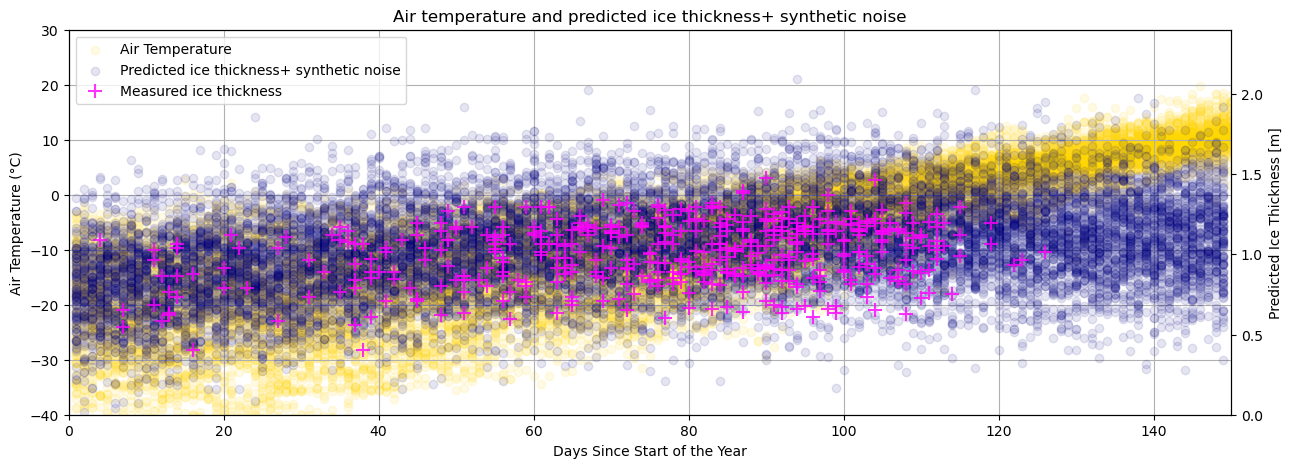

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Scatter plot for air temperature
ax.scatter(Data['Days since start of year'], Data['Regional: Air temperature [C]'], color="gold", alpha=0.1, label='Air Temperature')
ax.set_xlabel('Days Since Start of the Year')
ax.set_ylabel('Air Temperature (°C)')
ax.tick_params(axis='y')
ax.set_title('Air temperature and predicted ice thickness+ synthetic noise')
ax.set_ylim([-40,30])
ax.grid(True)

# Plot the second dataset on the second axis
ax2 = ax.twinx()
ax2.scatter(Data['Days since start of year'],Data['Noisy predicted ice thickness [m]'], color="navy", alpha=0.1, label='Predicted ice thickness+ synthetic noise')
ax2.scatter(Data['Days since start of year'],Data["IceThickness [cm]"]/100, color="magenta", alpha=0.8, label='Measured ice thickness',marker='+',s=100)
ax2.set_ylabel('Predicted Ice Thickness [m]')


# Combine legends
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2
ax.legend(handles, labels, loc='upper left')
ax.set_xlim([0,150])
ax2.set_ylim([0,2.4])



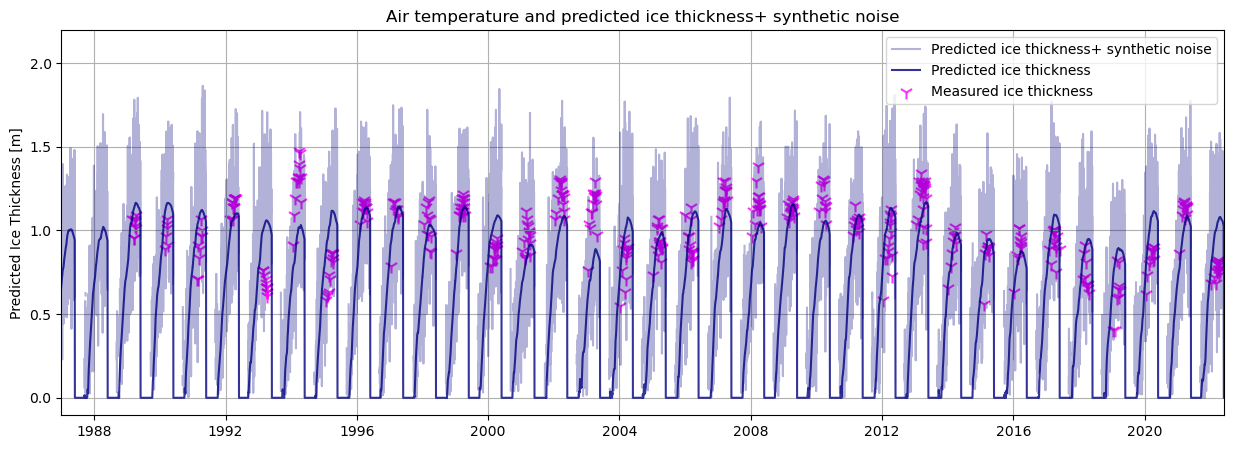

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Scatter plot for air temperature

ax.set_title('Air temperature and predicted ice thickness+ synthetic noise')
ax.grid(True)


ax.plot(Data['Noisy predicted ice thickness [m]'], color="navy", alpha=0.3, label='Predicted ice thickness+ synthetic noise')
ax.plot(Data['Predicted ice thickness [m]'], color="navy", alpha=0.8, label='Predicted ice thickness')
ax.scatter(Data.index,Data["IceThickness [cm]"]/100, color="magenta", alpha=0.8, label='Measured ice thickness',marker='1',s=100)
ax.set_ylabel('Predicted Ice Thickness [m]')
ax.set_xlim([pd.to_datetime('1987-01-01'),pd.to_datetime('2022-06-01')])
ax.legend()


# Show plot
plt.show()


Waht we learned:
- The prediction seem adequate (compute GOF metrics) for our purpose of *data augmentation*  of ice thickness data. It is a very simple model, with a few simplification and assumption (see column description), but at least its a good first approach.
- Our model, does a reasonably good job of estimating ice-growth, but a very bad job at estimating ice-melting, if we just use the ODE to estimate ice thickness, the ice does not melt through summer, and carries on to the next winter, accumulating. This is probably due to the ice breaking-up and then melting instead of it breaking up, when it has melted. We had to force zero ice thickness in the summer to achieve reasonable result ( again see column description for more info)
- Ice break up, depends on more that just temperature and ice-thickness


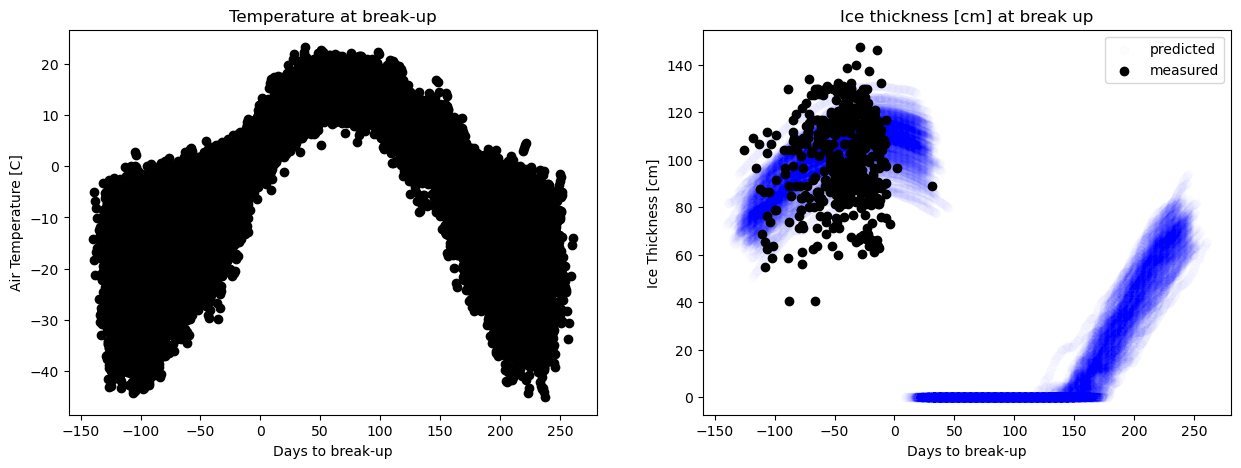

In [13]:

# Show plot
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(Data['Days until break up'],Data['Regional: Air temperature [C]'],color='k')
ax[0].set_title("Temperature at break-up")
ax[0].set_ylabel("Air Temperature [C]")
ax[0].set_xlabel("Days to break-up")
ax[1].scatter(Data['Days until break up'],Data['Predicted ice thickness [m]']*100,color='b',alpha=0.01,label='predicted')
ax[1].scatter(Data['Days until break up'],Data['IceThickness [cm]'],color='k',label='measured')
ax[1].set_title("Ice thickness [cm] at break up")
ax[1].set_ylabel("Ice Thickness [cm]")
ax[1].set_xlabel("Days to break-up")
ax[1].legend()
plt.show()

Lets take a closer look around $\pm$ 10 days from break-up

> check on ice thickness data point for ~25 after break up??? probably a mistake, identify which year is it see if it is transcript mistake or some other mistake ( Ice thickness data was manually transcribed frmo the  web-page so it is probably a msitake)

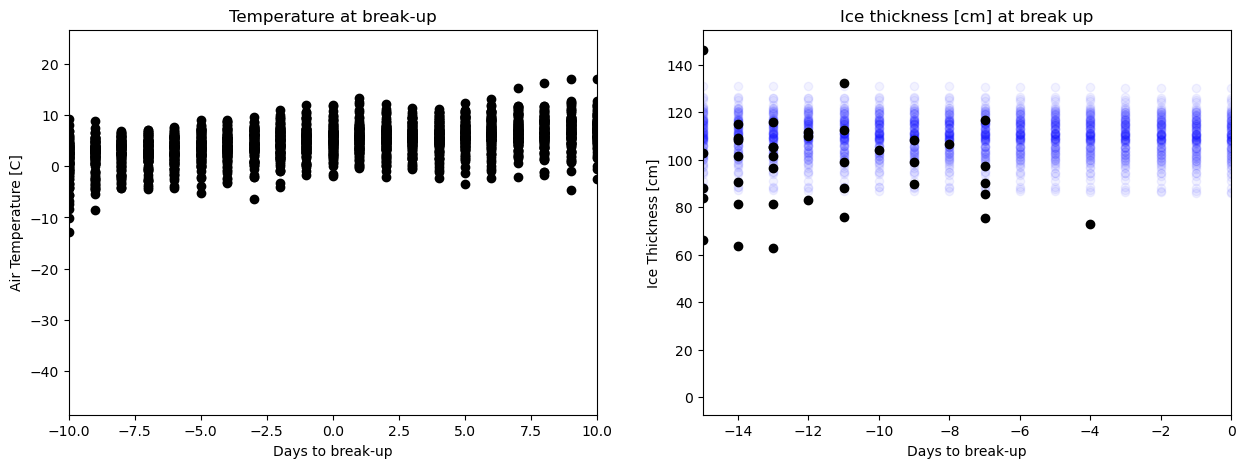

In [14]:
# Show plot
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(Data['Days until break up'],Data['Regional: Air temperature [C]'],color='k')
ax[0].set_title("Temperature at break-up")
ax[0].set_ylabel("Air Temperature [C]")
ax[0].set_xlabel("Days to break-up")
ax[0].set_xlim([-10,10])
ax[1].scatter(Data['Days until break up'],Data['Predicted ice thickness [m]']*100,color='b',alpha=0.05,label='predicted')
ax[1].scatter(Data['Days until break up'],Data['IceThickness [cm]'],color='k',label='measured')
ax[1].set_title("Ice thickness [cm] at break up")
ax[1].set_ylabel("Ice Thickness [cm]")
ax[1].set_title("Ice thickness [cm] at break up")
ax[1].set_ylabel("Ice Thickness [cm]")
ax[1].set_xlabel("Days to break-up")
ax[1].set_xlim([-15,0])
plt.show()

What we learned:
- Temperature might have information about the break up date
    - maybe play aorudn with auto correlation, # days where temperature has been over 0, etc.
- Ice thickness 
    - Clearly need more work, maybe categorize the *type* of break up ( lets remember that the time of break-up is defined when the tripod moves down-stream 100ft setting off a pulley-clock system, and not directly the ice break-up)

### Discharge
Maybe, discharge data might clarify the picture, as we suspect that the break-up mechanism is different that the one causing the ice to melt.


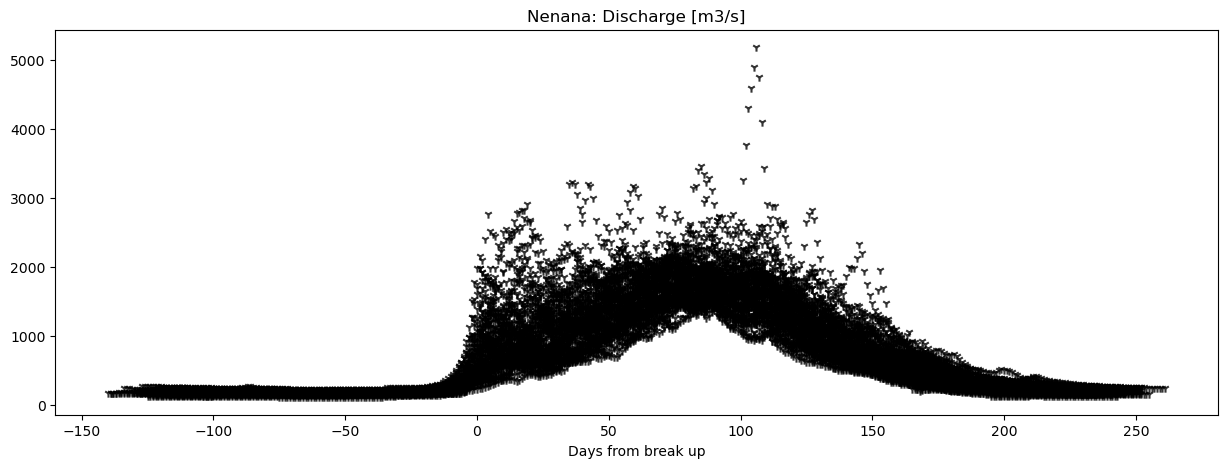

In [44]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5)) 
plt.scatter(Data['Days until break up'],Data['Nenana: Mean Discharge [m3/s]'],color='k',marker='1',alpha=0.8,label='Regional Temp')
plt.xlabel('Days from break up')
plt.title("Nenana: Discharge [m3/s]")
plt.show()


There is an obvious correlation, the question is 
>¿ Does the increase in discharge, affect the break up of the ice?

or

> ¿ Does the break up the ice allows the discharge measurements to be made?

Probably the latter one.
We can quickly check by plotting the time series and the break up dates

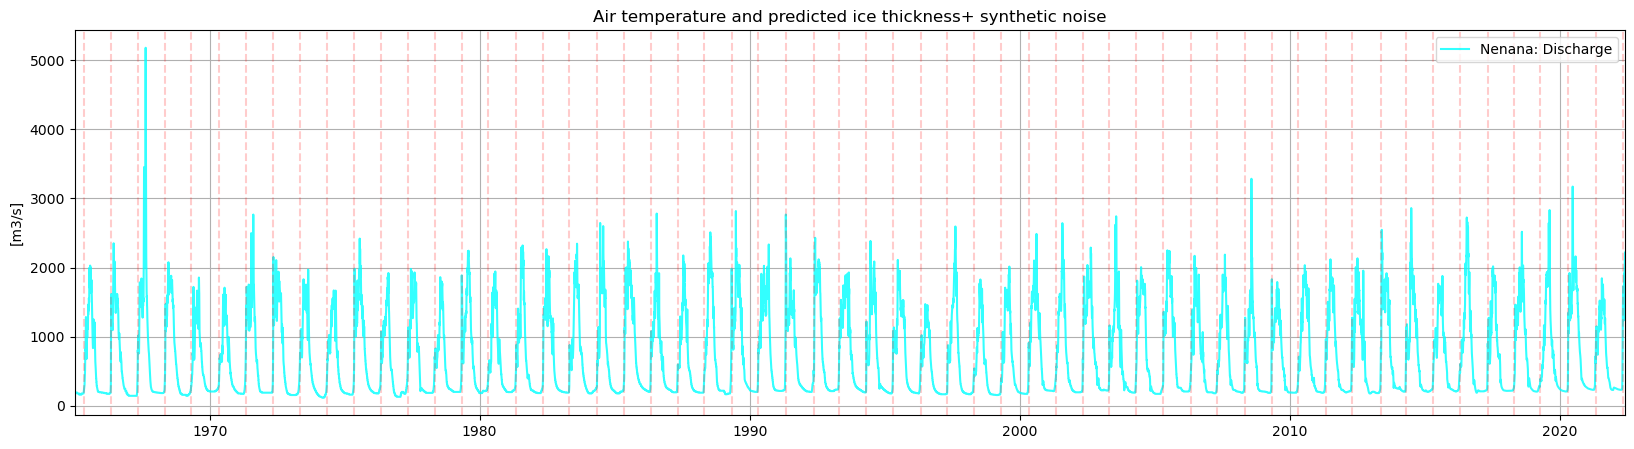

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_title('Air temperature and predicted ice thickness+ synthetic noise')
ax.grid(True)


ax.plot(Data['Nenana: Mean Discharge [m3/s]'], color="aqua", alpha=0.8, label='Nenana: Discharge')
ax.set_ylabel( '[m3/s]')
ax.set_xlim([pd.to_datetime('1965-01-01'),pd.to_datetime('2022-06-01')])
ax.legend()
# Plot vertical lines where the values are 0= break up date
zero_indices = Data.index[Data['Days until break up'] == 0]
for zero_index in zero_indices:
    plt.axvline(x=zero_index, color='r', linestyle='--',alpha=0.2)


# Show plot
plt.show()

Not  100 % clear, lets compute the change of discharge

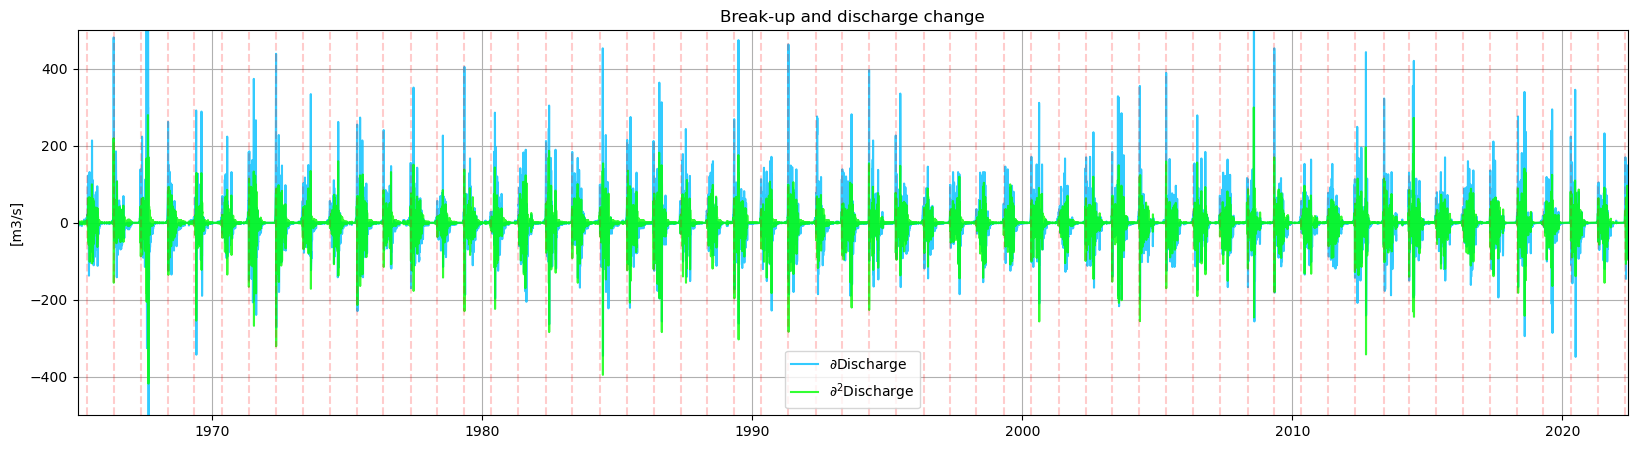

In [42]:
dy_dx = np.gradient((Data['Nenana: Mean Discharge [m3/s]']))
dy2_dx = np.gradient(dy_dx)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_title('Break-up and discharge change')
ax.grid(True)


ax.plot(Data.index,dy_dx, color="deepskyblue", alpha=0.8, label=r'$\partial$'+ 'Discharge')
ax.plot(Data.index,dy2_dx, color="lime", alpha=0.8,label=r'$\partial^2$'+ 'Discharge')
ax.set_ylabel( '[m3/s]')
ax.set_xlim([pd.to_datetime('1965-01-01'),pd.to_datetime('2022-06-01')])
ax.legend()
# Plot vertical lines where the values are 0= break up date
zero_indices = Data.index[Data['Days until break up'] == 0]
for zero_index in zero_indices:
    plt.axvline(x=zero_index, color='r', linestyle='--',alpha=0.2)

plt.ylim([-500,500])
# Show plot
plt.show()

What we learned:
- A visual inspection corroborates our hypothesis, the measured increase in discharge is probably due to break up of ice allows the measurement of discharge.
- Local discharge data is not useful
- Add and check up-stream discharge (the Fairbanks discharge data is in the Noaa-Fairbanks file, but i haven checked or added the data)
- Waht about ice-melting ? Might give information


## Glaciar Data

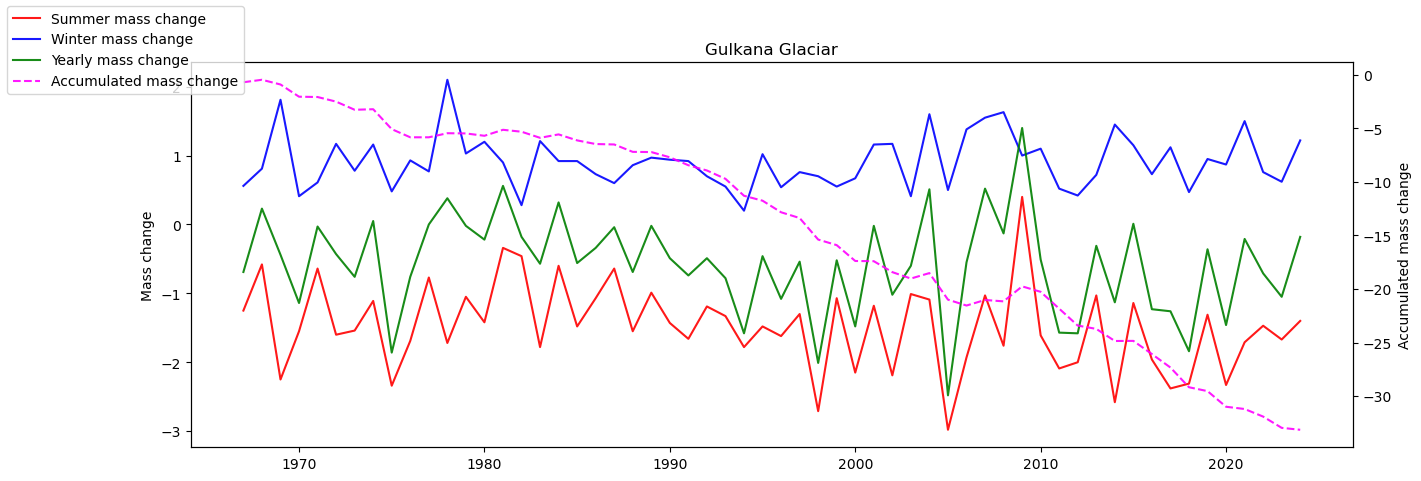

In [60]:
Glaciar_summer=Data['Gulkana: Glacier-wide summer mass balance [m.w.e]'].copy().resample('Y').mean().dropna()
Glaciar_winter=Data['Gulkana: Glacier-wide winter mass balance [m.w.e]'].copy().resample('Y').mean().dropna()
Glaciar_year=Glaciar_winter+Glaciar_summer


fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
ax1.plot(Glaciar_summer, label='Summer mass change', alpha=0.9, color='r')
ax1.plot(Glaciar_winter, label='Winter mass change', alpha=0.9, color='b')
ax1.plot(Glaciar_year, label='Yearly mass change', alpha=0.9, color='g')
ax1.set_ylabel('Mass change')


ax2 = ax1.twinx()

integral = Glaciar_year.cumsum()
ax2.plot(Glaciar_year.index, integral, label='Accumulated mass change', alpha=0.9, color='magenta',linestyle='--')
ax2.set_ylabel('Accumulated mass change')

# Set title and legend
plt.title('Gulkana Glaciar')
fig. legend(loc='upper left')

plt.show()

very broad questions
- On the original file there is column ELA ( equilibrium altitude), from the documentation is seem to be the altitude of the glaciar, which is the obviously related to the accumulated mass change, which variable is best to use?
- There might be some frequency signal in the data, is it related to global indexes?
- Correlation with temperature and precipitation
- Correlation with discharge? might gives a way to estimate volume of water? 
- Investigated break up mechanism
    - Does the volume of water that the ice is holding up  create a pressure differential that initiates the break-up, maybe just melting,  maybe influence of speed of once the 'blockage has been broken up' 
     - Is discharge in winter actually zero??? from where i come from river are too fast to feeze for the temperature that we have.
     - Might be able to relate volume of melted ice+precipitation+ upstream discharge??? Maybe one of the hydraulic guys knows if this even makes sense or i it possible to get estimate.
- Does diving into the Glaciar-river rabbit-hole makes sense?? or Just blindly feed to data to ML??